Detected Red traffic light with brightness 152.47920792079208


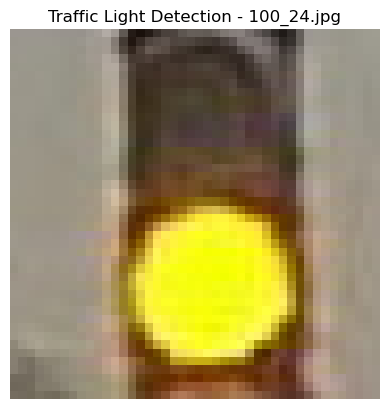

In [53]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def preprocess_traffic_light(image):
    # 转换为HSV颜色空间
    img_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    # 定义红色、黄色、绿色的HSV范围
    # lower_red1 = np.array([0, 30, 90])     # 扩展红色下限，确保更暗的红色
    # upper_red1 = np.array([15, 255, 255])  # 扩展上限到 20
    # lower_red2 = np.array([160, 30, 90])   # 调整第二个红色的下限
    # upper_red2 = np.array([180, 255, 255])
    
    # lower_yellow = np.array([20, 100, 150])
    # upper_yellow = np.array([30, 255, 255])
    
    # lower_green = np.array([75, 50, 100])  # 扩展到青绿色
    # upper_green = np.array([95, 255, 255]) 

    # 红色范围
    lower_red1 = np.array([0, 30, 100])
    upper_red1 = np.array([22, 255, 255])

    lower_red2 = np.array([160, 30, 100])
    upper_red2 = np.array([180, 255, 255])

    # 黄色范围
    lower_yellow = np.array([22, 80, 100])
    upper_yellow = np.array([35, 255, 255])

    # 绿色范围
    lower_green = np.array([75, 50, 100])
    upper_green = np.array([95, 255, 255])

    
    # 创建颜色掩码，分别为红色、黄色、绿色
    mask_red1 = cv.inRange(img_hsv, lower_red1, upper_red1)
    mask_red2 = cv.inRange(img_hsv, lower_red2, upper_red2)
    mask_red = cv.bitwise_or(mask_red1, mask_red2)
    
    mask_yellow = cv.inRange(img_hsv, lower_yellow, upper_yellow)
    mask_green = cv.inRange(img_hsv, lower_green, upper_green)
    
    # 合并颜色掩码
    masks = {
        "Red": mask_red,
        "Yellow": mask_yellow,
        "Green": mask_green
    }

    # 变量用于保存最高亮度的圆形
    max_brightness = -1
    best_circle = None
    best_color = None

    # 遍历红、黄、绿三个颜色，分别检测圆形并比较亮度
    for color_name, mask in masks.items():
        # 对原图进行掩码操作，只保留红绿灯区域
        masked_img = cv.bitwise_and(image, image, mask=mask)
        
        # 转换为灰度图
        gray = cv.cvtColor(masked_img, cv.COLOR_BGR2GRAY)
        
        # 使用 Hough Circle Transform 查找圆
        circles = cv.HoughCircles(
            gray, 
            cv.HOUGH_GRADIENT, 
            dp=1.2, 
            minDist=30, 
            param1=50, 
            param2=30, 
            minRadius=5, 
            maxRadius=50
        )
        
        # 如果检测到了圆形，检查亮度
        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")

            for (x, y, r) in circles:
                # 获取圆的亮度，使用 V 通道 (亮度)
                mask_circle = np.zeros_like(gray)
                cv.circle(mask_circle, (x, y), r, 255, -1)  # 创建圆形掩码
                
                # 检查掩码是否包含有效像素
                if np.sum(mask_circle[y-r:y+r, x-r:x+r]) == 0:
                    continue  # 如果没有有效像素，跳过该圆形
                
                brightness = np.mean(img_hsv[y-r:y+r, x-r:x+r, 2][mask_circle[y-r:y+r, x-r:x+r] > 0])  # 计算亮度平均值
                
                # 更新最高亮度圆的信息
                if brightness > max_brightness:
                    max_brightness = brightness
                    best_circle = (x, y, r)
                    best_color = color_name
    
    # 如果找到了亮度最高的圆
    if best_circle is not None:
        x, y, r = best_circle
        # 不再绘制圆形，直接进行裁剪
        
        # 裁剪出圆形区域
        x_min = max(0, x - r)
        x_max = min(image.shape[1], x + r)
        y_min = max(0, y - r)
        y_max = min(image.shape[0], y + r)
        
        cropped_image = image[y_min:y_max, x_min:x_max]
        print(f"Detected {best_color} traffic light with brightness {max_brightness}")
        return cropped_image
    
    # 如果未找到合适的圆形，返回原图
    return image

# 测试代码
image_paths = ["tlights/100_24.jpg"]  # 你上传的图片路径
for image_path in image_paths:
    image = cv.imread(image_path)
    
    if image is not None:
        cropped_image = preprocess_traffic_light(image)
        # 使用 matplotlib 在 Jupyter 中显示图片，无论是原图还是裁剪后的图像
        plt.imshow(cv.cvtColor(cropped_image, cv.COLOR_BGR2RGB))
        plt.axis('off')  # 不显示坐标轴
        plt.title(f"Traffic Light Detection - {image_path.split('/')[-1]}")
        plt.show()
    else:
        print(f"无法读取图片：{image_path}")
